# TP Observations Nocturnes - LU3PY232
**ARGUELLO Camilo**

In [1]:
%load_ext autoreload
%autoreload 2

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from utils import pc2m, m2pc, dms2deg, deg2dms, flux2mag, mag2flux, distance_modulus, apparent_to_absolute_flux
from constants import ConstantesAstro
from matplotlib.colors import LogNorm
from astropy.stats import sigma_clip
import os 
import glob
import warnings
#import astroalign as aa
from photutils.aperture import aperture_photometry, CircularAperture
from photutils.centroids import centroid_quadratic
import processing as  pr
import utils
from IPython.display import display, Math

## 1. Introduction et Contexte

### Objectifs du TP

Ce TP vise à étudier la relation d’échelle entre la taille et la luminosité des galaxies de l’univers proche. 
Nous allons utiliser des images obtenues à l'aide de télescopes à distance pour :

- Calibrer des images photométriques (offset, flat field),
- Extraire des informations scientifiques (taille, luminosité),
- Comparer les résultats avec les théories d’assemblage galactique.


### Diversité morphologique des galaxies

Les galaxies dans l'univers présentent une diversité morphologique remarcable. Dans la literature, on trouve qu'elles sont classifiées selon la séquence de Hubble, où on peut remarquer quelques groupes: 

- **Les galaxies elliptiques**, avec une forme ovoïde. [XX]
- **Les galaxies spirales**, comme par exemple notre Voie Lactée, possèdent un disque aplati avec des bras spiraux où se concentre la formation stellaire, entourant un bulbe central plus dense. [XX]
- **Les galaxies irrégulières**, qui ne montren pas une structure définie, et qui sont souvent le résultat d'interactions gravitationnelles.

Dans ce TP on se concentrerà sur celles **elliptiques** et **spirales**.

### Loi d'échelle taille-luminosité

$$R_e \propto L^\alpha$$

//  explication des relations taille-masse et leur interprétation physique


### Galaxie M83 (Messier 83)

Elle est l'une des galaxies spiraless les plus brillantes et les plus proches de la Terre. Situé à environ `4.66` Mpc. D'un point vue de ce TP elle constitue un excellent laboratoire pour étudier la structure et forme des galaxies spirales d'après son orientation face-à-face vers la Terre, ainsi que ces régions brillantes.

## 2. Prise en main et visualisation des images

Pour ce TP on est intéressés pour obtenir des informations par rapport des galaxies observables depuis le centre d'observation *Siding Spring Observatory (SSO)* en Australie (GMT+10). Pour ce faire on utilisera plusieurs outils:

- Dans un premier temps, on planifiera une observation sur la plateforme Astrometrique.net pour connaitre à partir d'une centre d'observation et sur une période donnée les possibles galaxies à observer. Y compris le temps d'exposition et l'heure de passage.
- En suite, nous allons obtenir faire une demande d'observation sur la plateforme [itelescope.net](https://itelescope.net). On choisira d'abord un Telescope, selon la disponibilité. Parmi les telescopes les plus utilises chez eux, nous allons utiliser le T17, le T32, et le T33. Pour cela on creera un script qui contiendra l'information par rapport la galaxie a observer, les binings et un temps d'exposition d'environ 300s. Cet outil permet aussi d'obtenir des observations sur une gamme differentes de filtres, on se concentrera sur les filtres rouge, bleu et vert qui nous donnent beaucoup plus de données.

- Ces informations on pourra les traiter après à l'aide de logiciel DS9, ainsi que avec du python et sa bibliothèque `photoutils` et `astrophy`.
- Pour rendre le TP plus facile à lire, on guardera toutes les fonctions crées dans le fichier `utils.py` et `processing.py`.

On commence dans un premiers temps à faire l'analyse pour les données recoltes par rapport la galaxie M83, un gallaxie assez connue et quie est observable depuis le SSO en Australie. On pourra donc dans la premier partie du TP, repondre aux questions avec ces données.

> Quel est l’ordre de grandeur de la brillance de surface des etoiles ?  la brillance de surface du fond de ciel ? La brillance de surface de la galaxie ? En quelle unit´e est le flux sur ces images non-calibrées ?

Dans le logiciel DS9, on mesure à la main les valeurs pour une région définie. Cette approach permettre d'obtenir la valeur moyenne. 

On choisi une zone et on fait deux ou trois mesures, avec l'outil: `X`, qui permet choisir une région en particulière puis obtenir la moyenne. Le tableau 1. montre les valeours obtenues. On a fait les mesures que pour le filtre rouge des images prises pour la galaxie M83. Le tableau avec toutes les mesures peut se trouver dans les appendices de cette rapport. $\small{TODO}$

| Zone     | Brillance de surface   |
|----------|------------------------|
| Étoiles  | $\approx 600 - 2500 $ |
| Fond de ciel  |  $\approx 600 - 700 $  |
| Galaxie  | $\approx 700 - 2300 $  |

$ \small{\text{Tableau 1. Grandeur de brillance selon la zone}} $



> Quelle est la durée de la pose ? Quelle était la date d’observation ?

Les fichiers *.fit sont très utilisés pour stocker une quantitée élevée d'information. Ils peuvent enregistrer des images, mais aussi des tableaux. Ces fichiers permet d'obtenir un `HEADER` ou (entête) et un `BODY` avec l'ensemble des données stockés. `HEADER` va nous permettre d'obtenir les valeurs de la durée de pose, ainsi que la date d'observation.

```ts
EXPTIME =   140.00000000000000 /Exposure time in seconds
DATE-OBS= '2023-05-09T11:32:42.84' /YYYY-MM-DDThh:mm:ss observation, UT
```

> Que pouvez-vous dire de la qualité de cette image ? Quelle est la valeur typique du fond de ciel ?

Pour les observations faites de la galaxie M83, on a des images brutes avec une qualitée bonne. Cependant on peut observer des traces dû a des erreurs dans la mesure, ainsi qu'une distribution non uniforme par rapporte le fond de ciel. Les étoiles apparaissent bien ponctuelles et définies, cependant on peut avoir quelques unes un peu saturées.

On fera une première visualisation des données avec la fonction `plot_initial_filter_sequence` pour afficher dans l'ensemble de filtres disponibles pour M83.

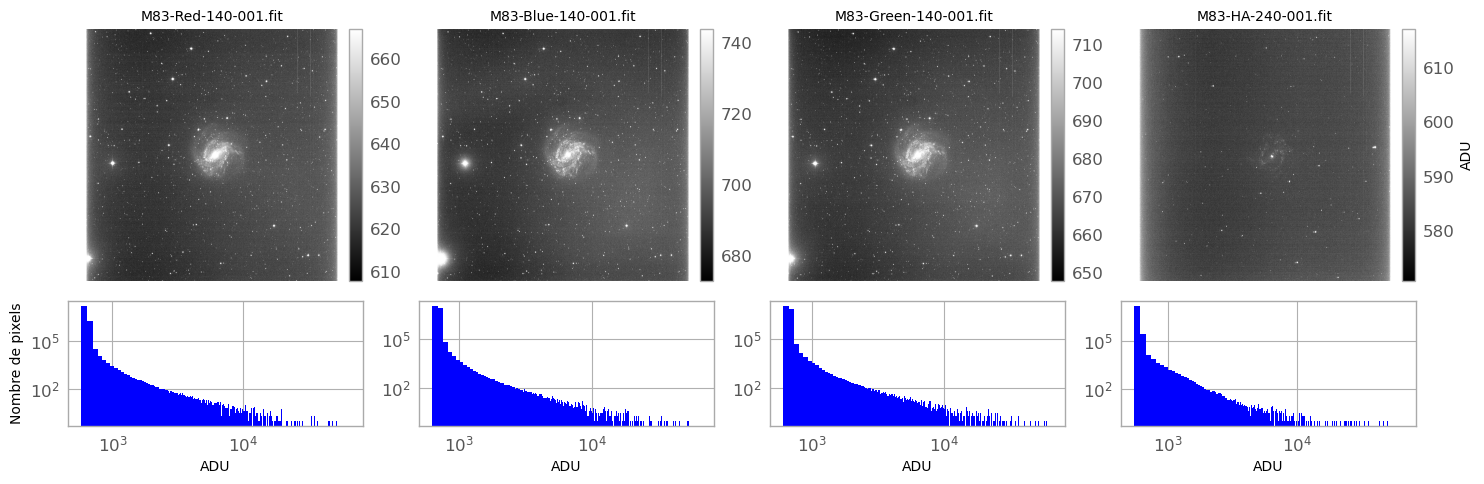

In [3]:
utils.plot_initial_filter_sequence()

> Répondez aux mêmes questions avec une image dans un autre filtre. Que constatez vous ? Faites bien attention à prendre en compte le temps de pose lorsque vous comparez les flux.

// TODO

> Convertissez la taille d’un pixel sur l’image en secondes d’arc puis en kiloparsecs, sachant la distance de cette galaxie (se référer au fichier excel `TP 2025 galaxies.xlsx`). Justifiez. En le mesurant “à la main”, quel est le rayon caractéristique ce cette galaxie, en `kpc` ?

In [75]:
# M83 
# Telescope: T32 dans l'observatoire SSO en Australie.
galaxy_name = "M83"
galaxy_type = 'spiral'
FOCALLEN = 2912            # distance focale en mm
XPIXSZ = 9e-3              # taille du pixel en mm (9 microns)
distance_mpc = 4.66        # distance depuis la Terre en Mpc
angular_size_arcsec = 600  # taille angulaire mesurée en arcsec

pixel_size = utils.get_pixel_size(XPIXSZ, FOCALLEN)  # arcsec / pixel
print(f"Pixel size théorique : {pixel_size:.3f} arcsec/pixel")

physical_size_pc, physical_size_kpc = utils.get_physical_size(angular_size_arcsec, distance_mpc)
print(f"Taille physique de la galaxie : {physical_size_pc:.2f} pc ({physical_size_kpc:.2f} kpc)")

Pixel size théorique : 0.637 arcsec/pixel
Taille physique de la galaxie : 13555.39 pc (13.56 kpc)


## 3. Calibration des images

Maintenant, nous nous intéressons à la calibration des images de M83. Lors des observations, plusieurs fichiers "bias" sont créés. Ces fichiers contiennent l'information des signaux électroniques parasites qui sont générés par le détecteur CCD en l'absence de toute source lumineuse. Ces acquisitions sont réalisées avec un temps d'exposition très court, de l'ordre de $0.001 s$ pour le télescope utilisé. Cette technique de calibration est essentielle car tous les capteurs CCD des appareils photo et télescopes ont un niveau de base non nul (piedestal électronique). En mesurant ce bias, on peut ensuite le soustraire des images scientifiques pour éliminer cette composante systématique du signal.

### Construction de la pose maitre d’offset

> Affichez l’histogramme des valeurs des pixels. Autour de quelle valeur se trouve l’offset piédestal ?

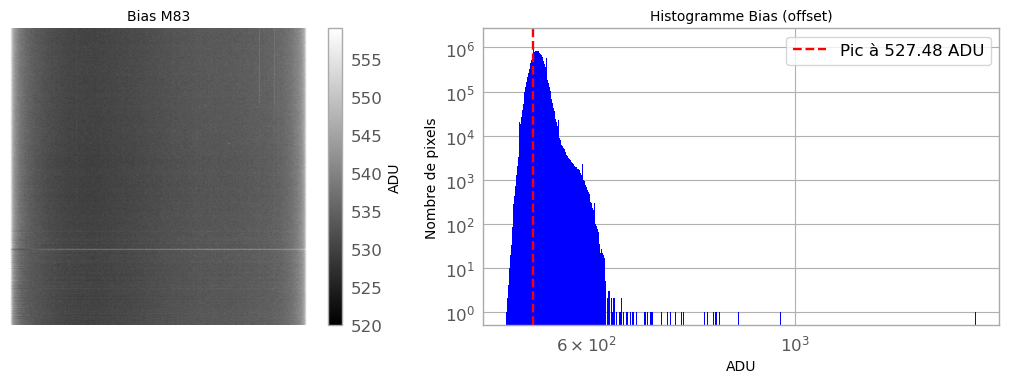

In [5]:
utils.plot_bias_hist('Bias/T32-fetedelascience-Bias-000-LD20230411-LT152814-BIN1.fit', 'M83')

Pour identifier la valeur sur l'offset (piédestal) on prend la valeur centrale de la distribution. On obtient un valeur du piédestal de `527.48` ADU.

Il est importante à remarquer que le bias est une mesure qui peut varier par pixel. Pour cela il faut créer plusieurs bias qui donneront une reduction dans le bruit statistique. Ce nouveau bias, on l'appelera "Master bias" qui sera un nouveau fichier composée par les valeurs moyennes de toutes les fichiers analyses.

Ce fichier on va le creer dans le dossier `/Processed` et on va s'en servir de la fonction `master_bias`. On pourra remarquer des petites améliorations du codage ont été faites pour cette fonction. En plus, on introduit la variable `sigma` liée à la fonction `sigma_clip(..)` qui va nous aider à filtrer les valeurs qui s'écartent trop de la valeur centrale.

In [6]:
output_dir = "./Processed/"
list_bias_name = glob.glob('./Bias/*.fit')

On se pose comme objectif trouver le meilleur valeur de la constante `sigma`. Cette valeur sera donc importante pour  bien refiner la medianne appliquée au bias. On calculera les differences d'appliquer uniquement la medianne et la medianne avec le sigma_clip(..). De même, on pourrait analyser le pourcentage de pixels modifiés en fonction de sigma.

Chargement de 13 poses de bias...


/opt/anaconda3/envs/LU3PY232/lib/python3.12/site-packages/astropy/stats/sigma_clipping.py:339: RuntimeWarning: invalid value encountered in _sigma_clip_fast
  bound_lo, bound_hi = _sigma_clip_fast(



Meilleur sigma: 3


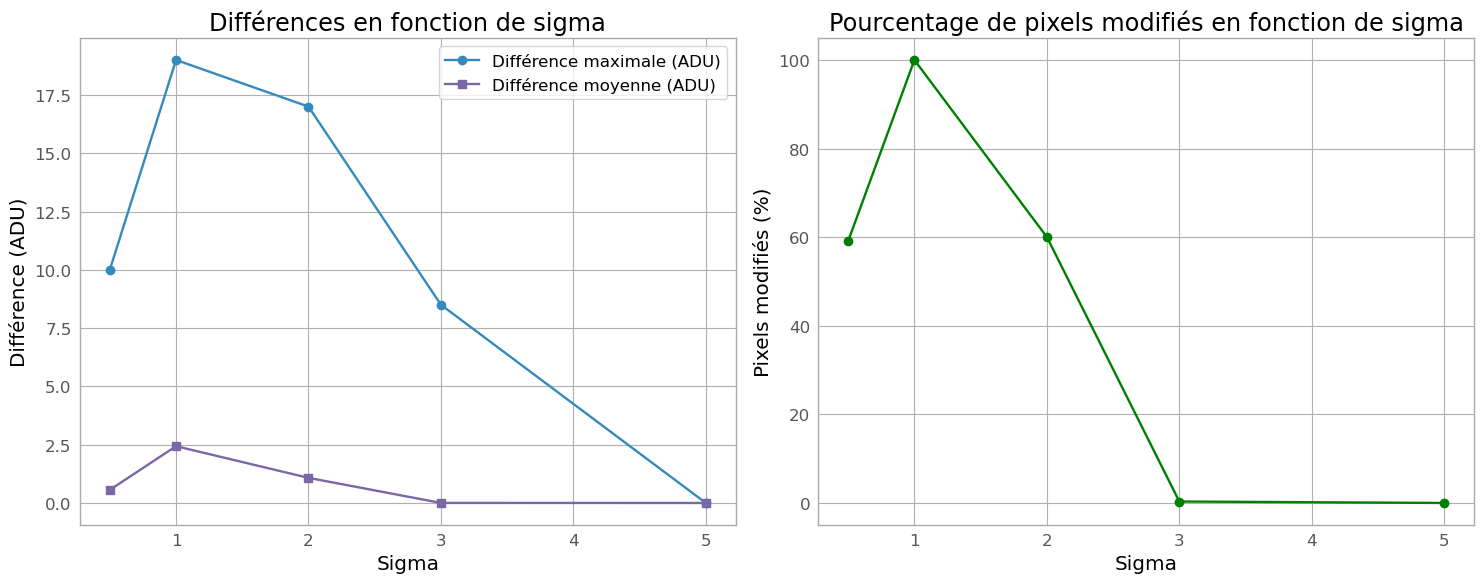

In [7]:
best_sigma, _, _ = pr.get_best_sigma_for_master_bias(list_bias_name)

À partir des valeurs de  $\sigma = 0.5$ jusqu'au $5$. On vérifie que les différences diminuent graduallement entre le filtre medianne (avec sigma) et celui sans. Cela est du a ...

In [8]:

master_bias, master_bias_name, master_bias_no_sigma = pr.master_bias(list_bias_name, out_dir=output_dir, out_name='masterbias.fits', overwrite=1, sigma=best_sigma, out_master_bias_no_sigma='masterbias_no_sigma.fits')

il y a 13 poses de bias dans la liste
le master bias a été sauvé en ./Processed/masterbias.fits
le master bias sans sigma a été sauvé en masterbias_no_sigma.fits


On pourra donc observer les differences entre les histogrammes avec et sans sigma. Ainsi que les images obtenues du master Bias. On voit de differences remarquables avec le filtre sigma.

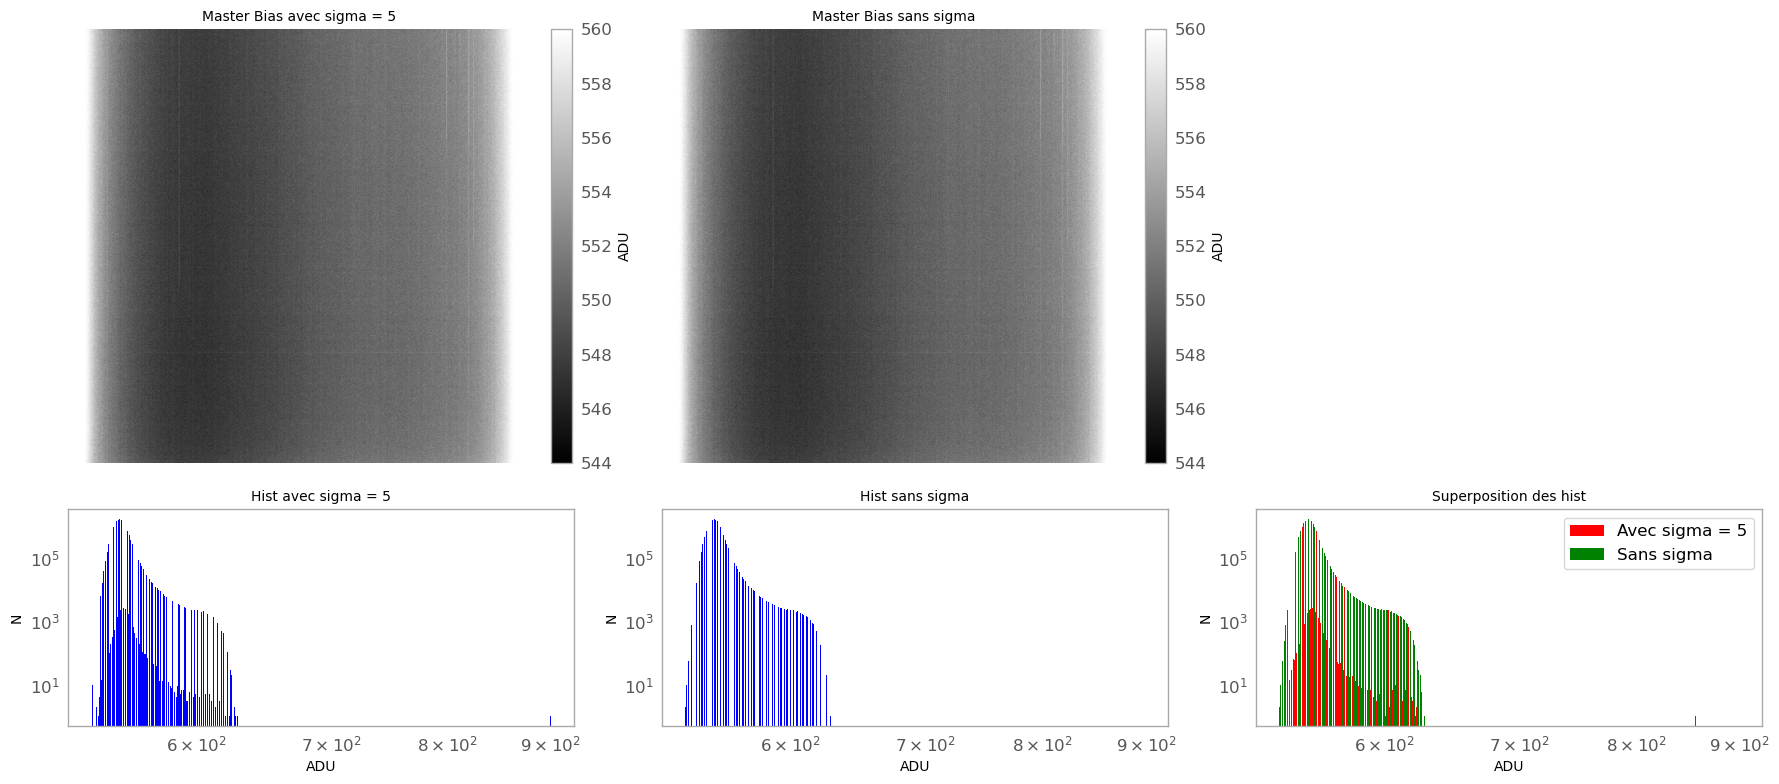

In [ ]:
files = [
    ('Processed/masterbias.fits', 'Master Bias avec sigma = ', True),
    ('Processed/masterbias_no_sigma.fits', 'Master Bias sans sigma', False)
]

utils.plot_bias_hist_sigma_stack(files, sigma=best_sigma)

In [10]:
# Charger une pose individuelle (exemple de la première image)
bias_example = fits.getdata(list_bias_name[0])

print("---- Pose individuelle ----")
print(f"Moyenne : {np.mean(bias_example):.2f}")
print(f"Ecart-type : {np.std(bias_example):.2f}")

print("---- Master Bias ----")
print(f"Moyenne : {np.mean(master_bias):.2f}")
print(f"Ecart-type : {np.std(master_bias):.2f}")

---- Pose individuelle ----
Moyenne : 555.11
Ecart-type : 9.05
---- Master Bias ----
Moyenne : 551.03
Ecart-type : 5.90


### Analyse des poses maitres de champ plat

> Quelle est la valeur moyenne des pixels ? En tracer l’histogramme. En pratique, à quoi correspond la correction de champ plat ? Comment la calibration est-elle obtenue ?

Une observation peut avoir d'autres difficultés pourqu'elle devient fiable. Soit par les variations de sensibilité du capteur ou de la poussière et vignetages optiques présentes lors du mésures, ou des pixels plus claires ou plus sombres à cause de l'instrument. Elle est fait avec une technique appellée `master_flat` qui permet calibrer l'image avec une division de l'image brute par une image flat qu'on obtient lors des observations. Ce procesus doit être en chaîne avec le bias pour obtenir un résultat cohérente.

Cela nous ramène à penser qu'une image final propre doit être soustraite d'après une image brute, une master bias, puis divisée par un master flat.

$$ I_{calibrée} = \frac{I_{brute} - Master Bias}{Master Flat}

Valeur moyenne des pixels: 1.00 ADU


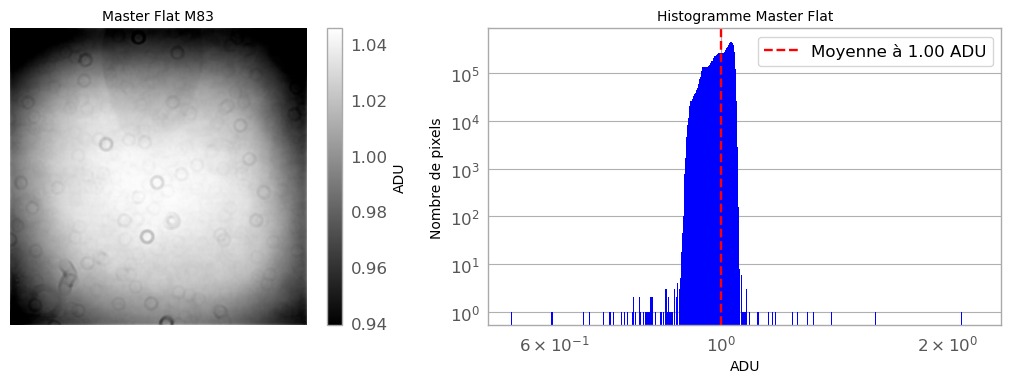

In [22]:
utils.plot_master_plat_hist('./flats_maitre/master_flat--Red-T32.fits', 'M83')

## 4. Pipeline de traitement

### Construction du pipeline de traitement des données

> Dessinez à la main le schéma correspondant au pipeline que vous allez construire et l’expliquer.

<img src="./schema.svg" width="50%" />  

1. Comme images input on a les images brutes, ainsi que les flat bruts qui seront des images que la plateforme peut nous fournir. (Il faut l'especifier lors de demande dans le script). De même on aura la possibilité d'obtenir des fichier `bias` que l'on combinera.
2. On pourra à l'aide de notre fonction `master_bias` construire le fichier que va etre soustraite de l'image brute.
3. Avec l'ensemble de fichiers `flat` et la fonction `master_flat` on pourra créer le fichier qui doit etre divise de l'image brute et le bias.
4. On obtient donc des images calibrées que l'on peut calculer des mesures photometriques.
5. Finalement on pourra obtenir la taille et assembler la galaxie selon le groupe qu'elle appartient

> Dans l’un des filtres, comparez l’image finale calibrée et une pose individuelle. Interprétez la différence.

pattern ./M83/M83-Red-*.fit
Trouvé 5 fichiers pour le filtre Red.
--- Pose individuelle ---
M83 Image brute : Moyenne : 627.93 ADU, Ecart-type : 259.41
--- Image finale stackée ---
M83 Image finale: Moyenne : 1.03 ADU, Ecart-type : 2.72


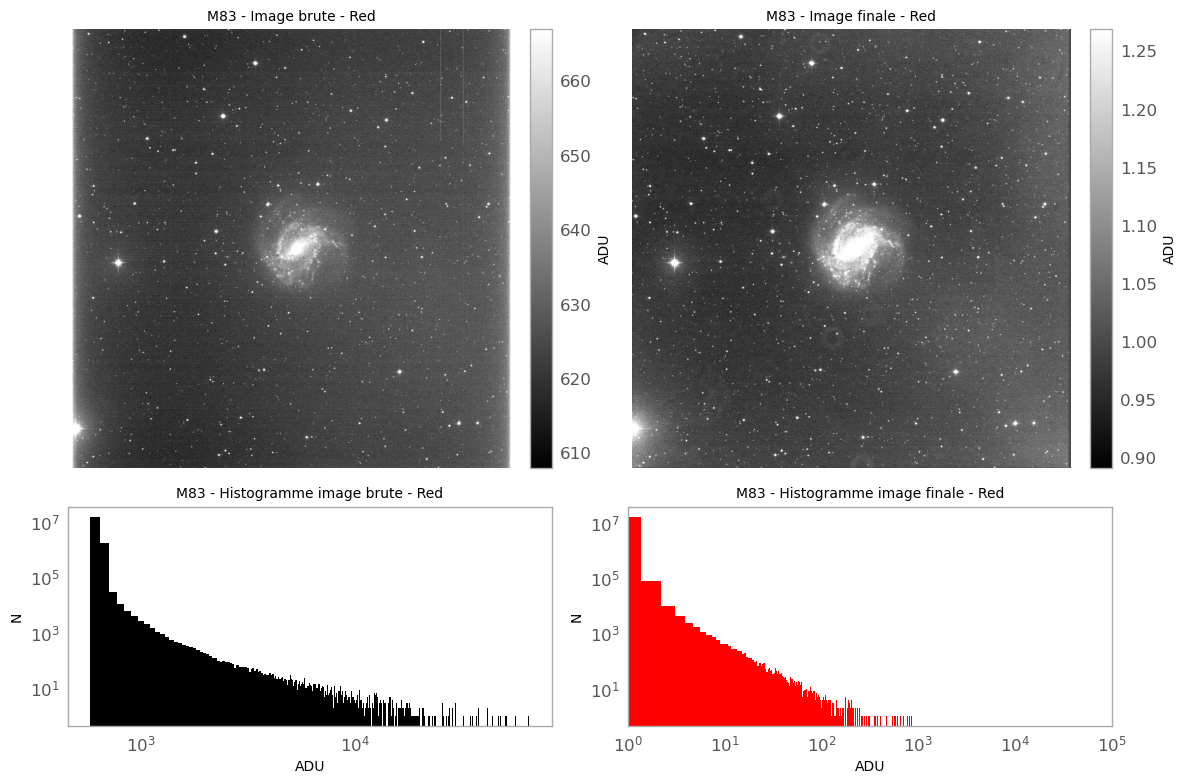

In [54]:
props = {
    'galaxy_name': 'M83',
    'input_folder': './M83/',
    'bias_path': './Processed/masterbias.fits',
    'flat_folder': './flats_maitre/',
    'output_folder': './Processed/',
    'color_init': 'black',
    'os': os
}
utils.plot_images_and_histograms({ **props, 'filter_name': 'Red', 'color_final': 'red',})

pattern ./M83/M83-Blue-*.fit
Trouvé 5 fichiers pour le filtre Blue.
--- Pose individuelle ---
M83 Image brute : Moyenne : 697.71 ADU, Ecart-type : 287.47
--- Image finale stackée ---
M83 Image finale: Moyenne : 1.02 ADU, Ecart-type : 1.98


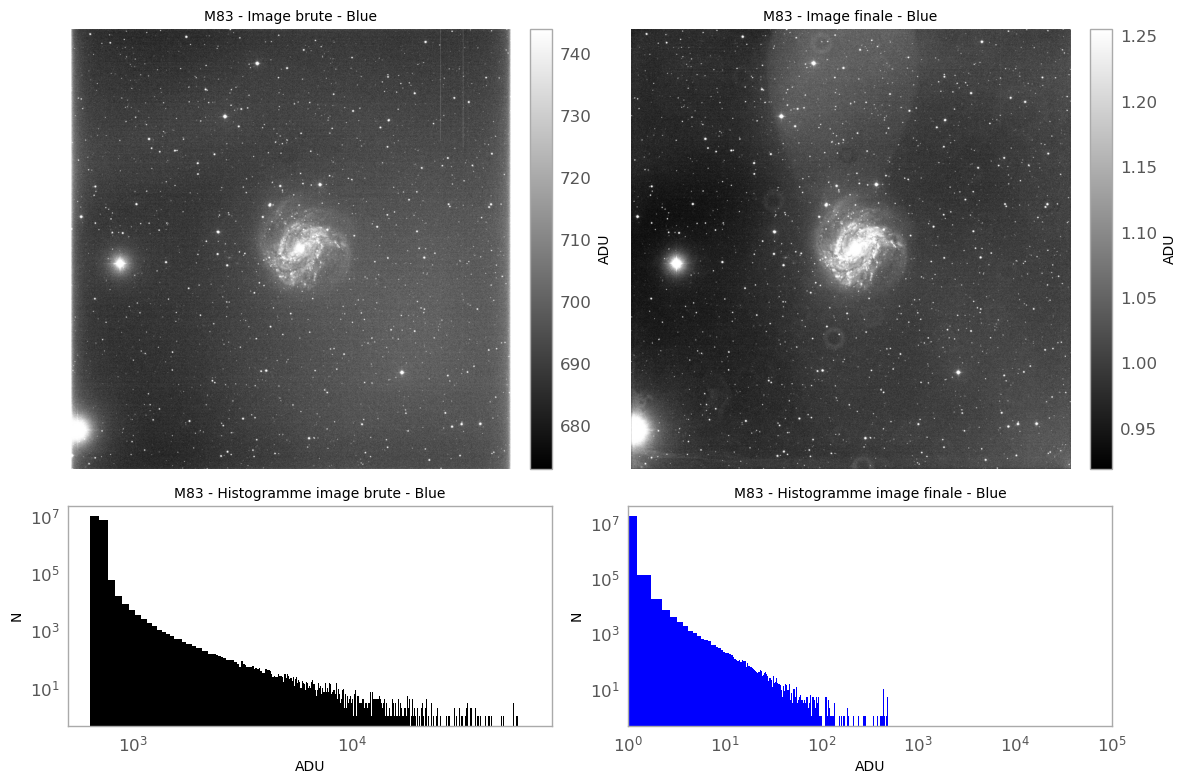

In [55]:
utils.plot_images_and_histograms({ **props, 'filter_name': 'Blue', 'color_final': 'blue'})

pattern ./M83/M83-Green-*.fit
Trouvé 5 fichiers pour le filtre Green.
--- Pose individuelle ---
M83 Image brute : Moyenne : 670.85 ADU, Ecart-type : 287.33
--- Image finale stackée ---
M83 Image finale: Moyenne : 1.03 ADU, Ecart-type : 2.45


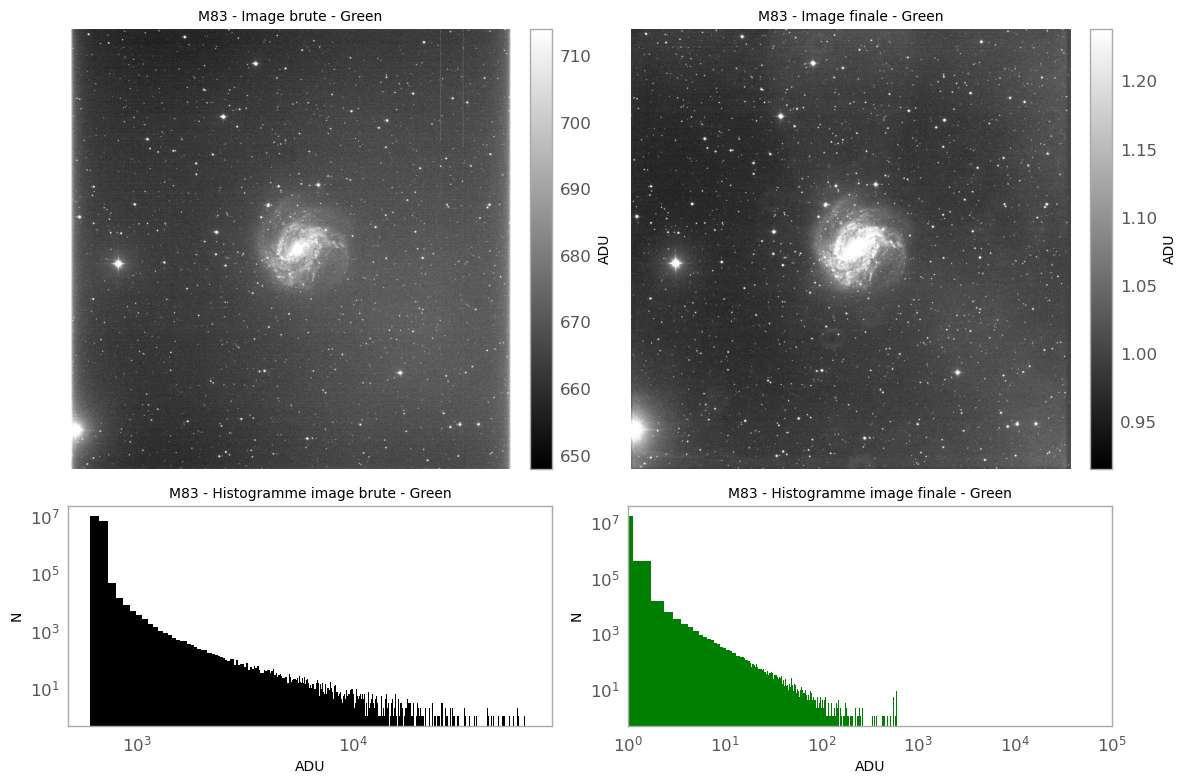

In [56]:
utils.plot_images_and_histograms({ **props, 'filter_name': 'Green', 'color_final': 'green' })

## 5. Photométrie : taille et luminosité

> Sachant la distance de la galaxie et la taille angulaire d'un pixel (spécifiées dans le [tableur excel](https://dropsu.sorbonne-universite.fr/apps/onlyoffice/s/KRR4sWN4dJsSjmg) ), calculer le facteur de conversion entre pixel et kpc pour cette galaxie.

In [24]:
pixel_size_kpc = utils.get_pixel_size_in_kpc(pixel_size, distance_mpc) # kpc/pixel
print(f"Taille du pixel : {pixel_size_kpc:.3f} kpc/pixel")

Taille du pixel : 0.014 kpc/pixel


> Calculer le flux de la galaxie dans differentes ouvertes entre 0.1 et 10kpc

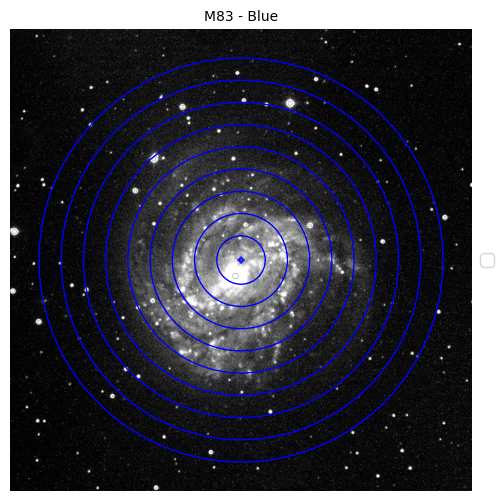

In [ ]:
image_calibrated = utils.get_image_calibrated('./Processed/M83_Blue_final_calibrated.fits')
rad_list = np.linspace(0.1,10,10) # kpc
flux_list, bckg = utils.return_flux(image_calibrated,rad_list,pixel_size_kpc,search_center=True,rm_background=True,diagnostic=True, galaxy_name='M83', filter_name='Blue', color='blue')

> Calculer the *total luminosity* and *the effective radius (radius that encloses half the total luminosity)*

In [82]:
lum,rad,rad_tot = utils.size_luminosity(rad_list,flux_list)
print(f"Le flux totale : {lum[0]:.2e} ADU")
print(f"Effective radius : {rad[0]} kpc")
print(f"Minimum radius : {rad_tot[0]} kpc")

Le flux totale : 9.28e+04 ADU
Effective radius : 4.5 kpc
Minimum radius : 10.0 kpc


> Les luminosités apparentes (`flux_list` et `lum`) sont en unite électronique. En utilisant le point zero indiqué dans le tableau excel, les convertir en magnitudes apparentes AB

In [81]:
zero_point = 19.05 # ZP for M83 with the T32 telescope

In [85]:
magnitudes = utils.calculate_magnitudes(flux_list, distance_mpc, rad_list, rad, zero_point)
print(f"La moyenne des magnitudes se trouve autour de {magnitudes['apparent_magnitudes'].mean():.2f} mag AB")
print(f"Magnitude effective {magnitudes['effective_magnitude']:.2f} mag AB")

La moyenne des magnitudes se trouve autour de 8.15 mag AB
Magnitude effective -21.09 mag AB


> Convertir les magnitudes apparentes en magnitudes rest-frame (c'est à dire à 10pc de la source)

In [86]:
print(f"La moyenne des magnitudes à 10pc de la source se trouve autour de {magnitudes['absolute_magnitudes'].mean():.2f} mag")

La moyenne des magnitudes à 10pc de la source se trouve autour de -20.19 mag


> Tracer l'evolution de la magnitude en fonction du rayon et ajouter une ligne verticale indiquant le rayon effectif

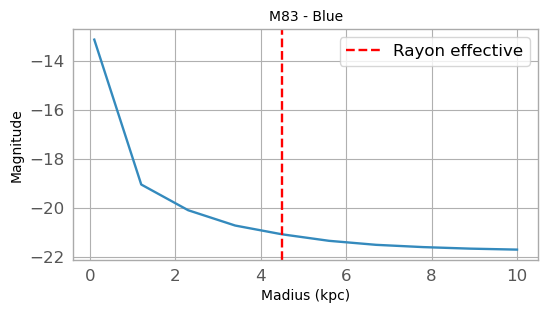

In [ ]:
utils.plot_radial_magnitudes(magnitudes, rad_list, rad, 'M83', 'Blue')

> Faire la meme chose pour les autres galaxies dont vous avez les images calibrées

Taille du pixel : 0.014 kpc/pixel


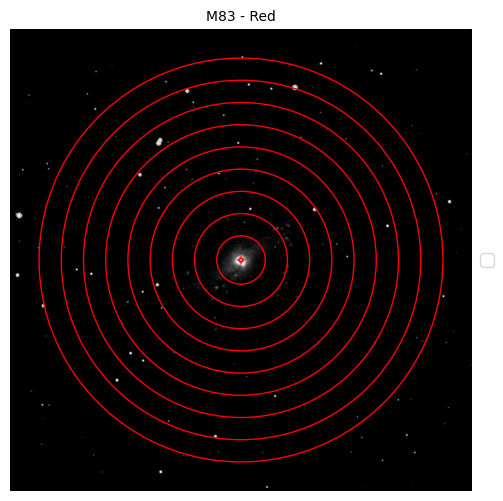

Le flux totale : 106578.03 ADU
Effective radius : 3.40 kpc
Minimum radius : 8.90 kpc
La moyenne des magnitudes se trouve autour de 7.37 mag AB
Magnitude effective -21.16 mag AB
La moyenne des magnitudes à 10pc de la source se trouve autour de -20.97 mag


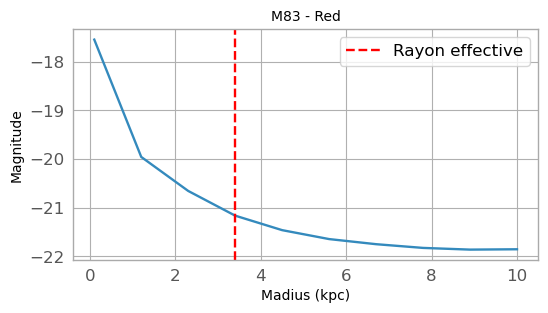

In [87]:
props = {
    'pixel_size' : pixel_size,
    'distance_mpc': distance_mpc,
    'galaxy_name': 'M83',
    'zero_point': 19.05
}
utils.process_size_luminosity({ **props, 'filter_name': 'Red', 'color': 'red' })

Taille du pixel : 0.014 kpc/pixel


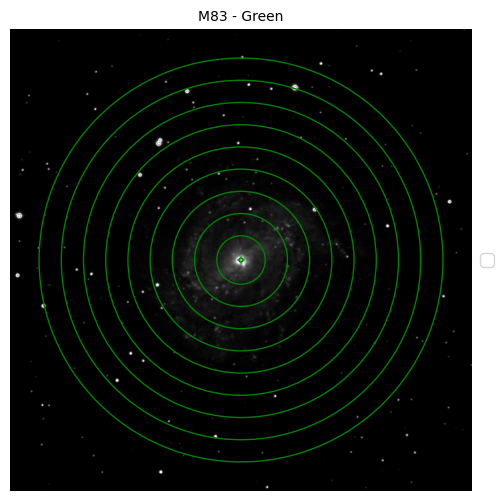

Le flux totale : 100099.92 ADU
Effective radius : 3.40 kpc
Minimum radius : 10.00 kpc
La moyenne des magnitudes se trouve autour de 7.52 mag AB
Magnitude effective -20.95 mag AB
La moyenne des magnitudes à 10pc de la source se trouve autour de -20.82 mag


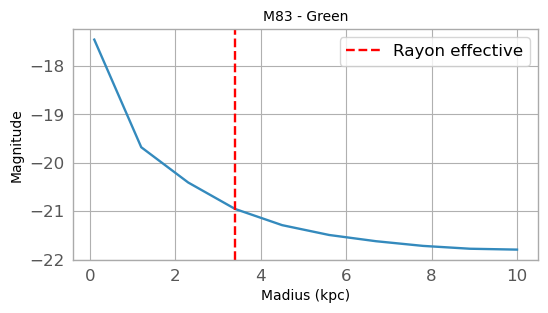

In [88]:
utils.process_size_luminosity({ **props, 'filter_name': 'Green', 'color': 'green' })

Taille du pixel : 0.014 kpc/pixel


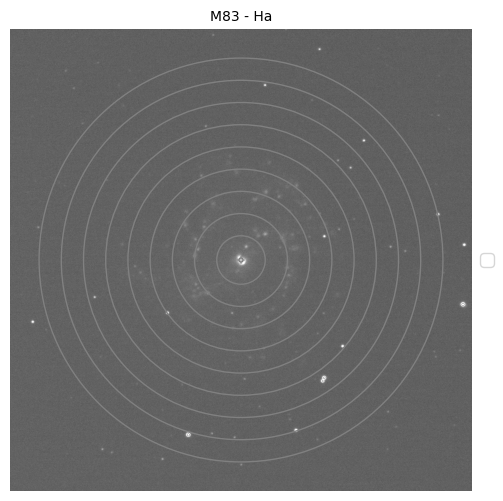

Le flux totale : 1514.59 ADU
Effective radius : 3.40 kpc
Minimum radius : 8.90 kpc
La moyenne des magnitudes se trouve autour de 11.92 mag AB
Magnitude effective -16.62 mag AB
La moyenne des magnitudes à 10pc de la source se trouve autour de -16.42 mag


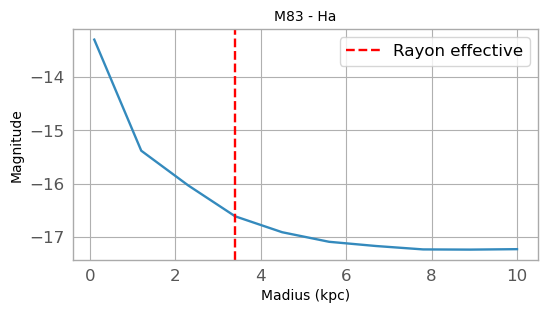

In [89]:
utils.process_size_luminosity({ **props, 'filter_name': 'Ha', 'color': 'gray' })

> Sur la figure ci-dessous, rajouter vos points de mesure (dans les panneaux correspondants)

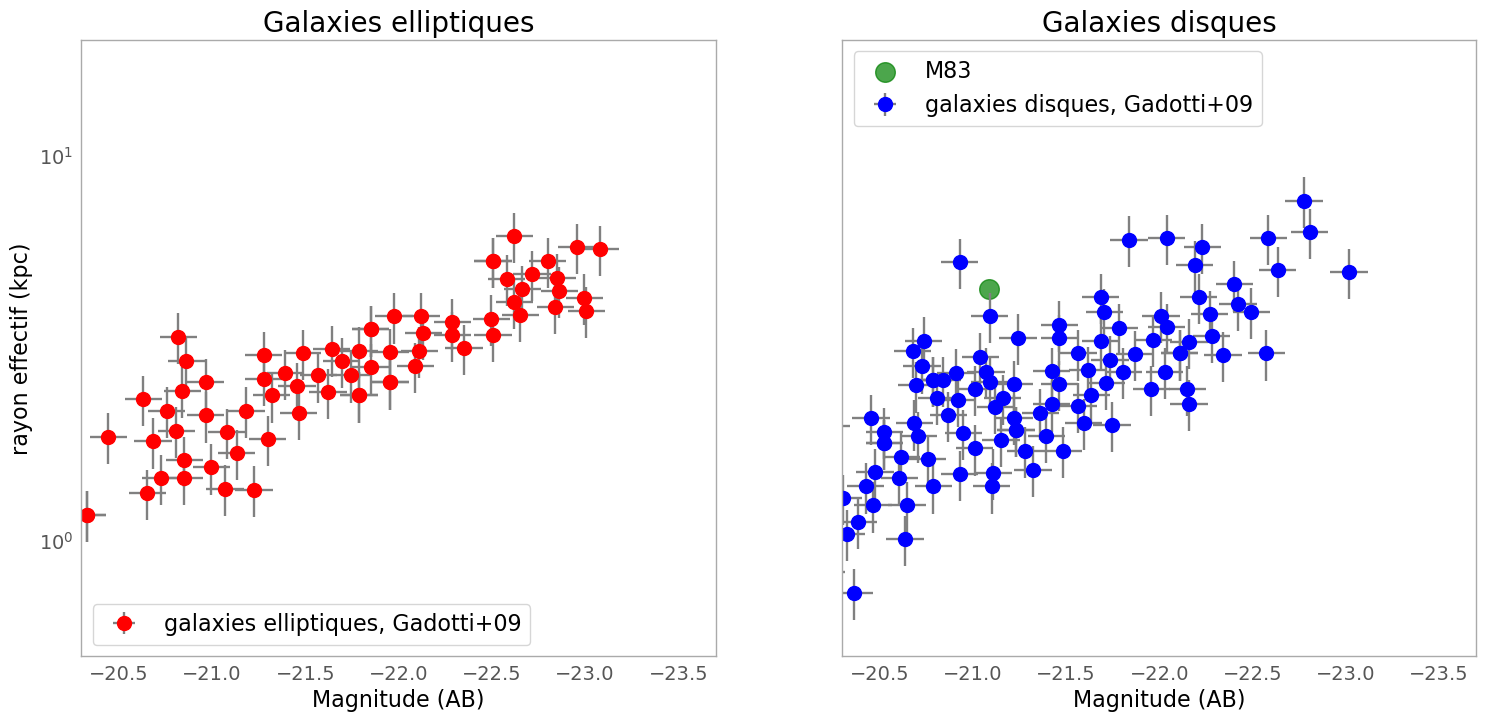

In [121]:
magz_ellipt, reff_ellipt, magz_disk, reff_disk = size_luminosity_data = utils.get_size_luminosity_data()
utils.plot_galaxies_with_incertitudes(magz_ellipt, reff_ellipt, magz_disk, reff_disk, magnitudes['effective_magnitude'], rad, galaxy_type, galaxy_name)

> Discuter des sources d'incertitudes, et des effets systematiques

// TODO

## 6. Prises de vue à partir de l’observatoire à distance

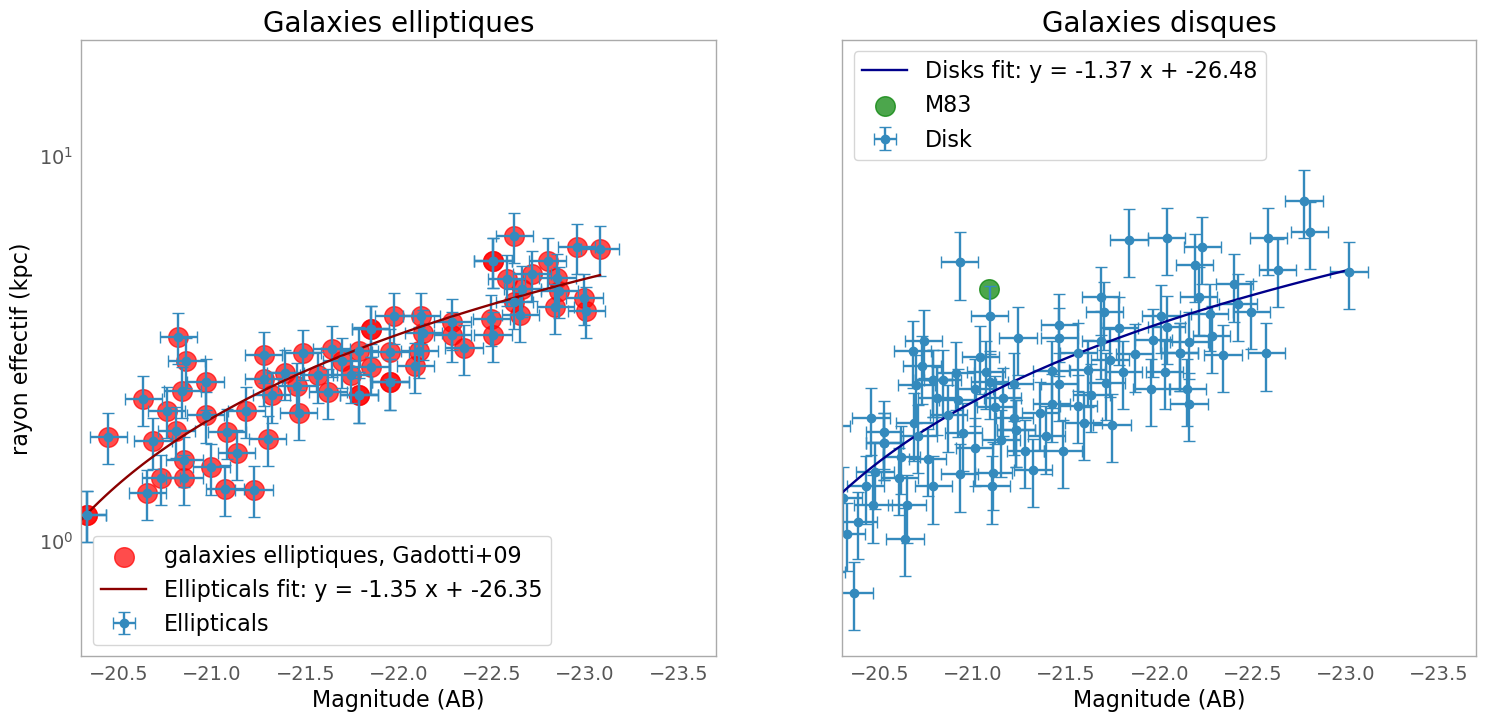

In [65]:
# ---- Linear fit for Elliptical Galaxies ----
coeffs_ell = np.polyfit(magz_ellipt, reff_ellipt, 1)
fit_ell = np.polyval(coeffs_ell, magz_ellipt)
# Estimate the scatter (standard deviation of residuals)
sigma_ell = np.std(reff_ellipt - fit_ell)

# ---- Linear fit for Disk Galaxies ----
coeffs_disk = np.polyfit(magz_disk, reff_disk, 1)
fit_disk = np.polyval(coeffs_disk, magz_disk)
sigma_disk = np.std(reff_disk - fit_disk)

# Generate fit lines for plotting
x_fit_ell = np.linspace(magz_ellipt.min(), magz_ellipt.max(), 100)
y_fit_ell = np.polyval(coeffs_ell, x_fit_ell)

x_fit_disk = np.linspace(magz_disk.min(), magz_disk.max(), 100)
y_fit_disk = np.polyval(coeffs_disk, x_fit_disk)

fig, axes = plt.subplots(1,2,figsize = (18,8),sharex=True,sharey=True)

## Panneau de gauche : galaxies elliptiques
ax = axes[0]
#ax.errorbar(magz_ellipt, reff_ellipt, yerr=sigma_ell, fmt='o', markersize=8,
#             color='red', alpha=0.7, label='Ellipticals Data')

magz_err = 0.1  # 0.1 mag uncertainty
reff_err = 0.15 * reff_ellipt  # 15% uncertainty on radius

# Plot with error bars
ax.scatter(magz_ellipt,reff_ellipt,s = 200,alpha=0.7,color='red',label = 'galaxies elliptiques, Gadotti+09')
ax.errorbar(magz_ellipt, reff_ellipt, 
             xerr=magz_err, yerr=reff_err, 
             fmt='o', label='Ellipticals', capsize=4)
# ax.scatter(M_eff,rad, color='green', s=200, alpha=0.7, label='M87 effective radius')
ax.plot(x_fit_ell, y_fit_ell, color='darkred',
         label=f'Ellipticals fit: y = {coeffs_ell[0]:.2f} x + {coeffs_ell[1]:.2f}')

ax.legend(loc = 'lower left', fontsize = 16)
ax.set_xlim(-20,-24)
ax.set_ylim(0.5,20)
ax.set_yscale('log')
ax.set_xlabel('Magnitude (AB)',fontsize=16)
ax.set_ylabel('rayon effectif (kpc)',fontsize=16)
ax.set_title('Galaxies elliptiques',fontsize = 20)
ax.grid()
## Panneau de droite : galaxies disques
ax1 = axes[1]


#x_d = disks["iMAGd"]
#y_d = disks["h"]
magz_err = 0.1
reff_err = 0.2 * reff_disk  # 20% uncertainty on scalelength

ax1.errorbar(magz_disk, reff_disk, 
             xerr=magz_err, yerr=reff_err, 
             fmt='o', label='Disk', capsize=4)
ax1.plot(x_fit_disk, y_fit_disk, color='darkblue',
         label=f'Disks fit: y = {coeffs_disk[0]:.2f} x + {coeffs_disk[1]:.2f}')
# ax1.scatter(magz_disk,reff_disk,color='blue',s = 200,alpha=0.7,label = 'galaxies disques, Gadotti+09')
# Add a point for the M87 galaxy effective radius (rad) and magnitude (mag_tot)
ax1.scatter(magnitudes['effective_magnitude'],rad, color='green', s=200, alpha=0.7, label='M83')
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_xlim(-20.3,-23.7)
ax1.set_ylim(0.5,20)
ax1.set_yscale('log')
ax1.set_xlabel('Magnitude (AB)',fontsize=16)
ax1.set_title('Galaxies disques',fontsize = 20)
ax1.grid()
for i in range(2):
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].tick_params(axis='both', which='minor', labelsize=14)
plt.show()

In [107]:
from astroquery.vizier import Vizier
import pandas as pd

# Set Vizier row limit (you can change or set to -1 for all available rows)
Vizier.ROW_LIMIT = -1

# Define only the columns we need
columns = [
    "MType", "MType2",  # Morphology
    "gMAGd", "rMAGd", "iMAGd",  # Disk magnitudes
    "gMAGbu", "rMAGbu", "iMAGbu",  # Bulge magnitudes
    "h", "re",  # Disk scalelength and Bulge effective radius
    "Blg/T", "D/T", "Bar/T",  # Component ratios
    "z",  # Redshift
    "(g-i)d", "(g-i)bu"  # Color indices
]

# Load the table: J/MNRAS/393/1531 (Dimitri A. Gadotti 2009)
catalog_id = "J/MNRAS/393/1531"
vizier = Vizier(columns=columns)
result = vizier.get_catalogs(catalog_id)

# The main table is usually the first one
data = result[0].to_pandas()

# Preview the dataframe
print("Total entries:", len(data))
print(data.head())

# Optional: Filter Elliptical vs Disk
# For example: classify "Elliptical" as MType starting with 'E', "Disk" with 'S' or 'Sb' etc.
ellipticals = data[data["MType"].str.startswith("E", na=False)]
disks = data[data["MType"].str.startswith("S", na=False)]

print("Ellipticals:", len(ellipticals))
print("Disks:", len(disks))

Total entries: 50
          MType    MType2  gMAGd      rMAGd      iMAGd     gMAGbu     rMAGbu  \
0     classical  unbarred -19.74 -20.580000 -20.959999 -19.330000 -19.940001   
1     classical  unbarred -20.18 -20.879999 -21.340000 -19.410000 -20.680000   
2  pseudo-bulge  unbarred -20.18 -20.639999 -20.940001 -15.820000 -16.860001   
3    elliptical  unbarred    NaN        NaN        NaN -20.680000 -21.389999   
4    elliptical  unbarred    NaN        NaN        NaN -20.610001 -21.379999   

   iMAGbu      h     re  Blg/T    D/T  Bar/T      z  (g-i)d  (g-i)bu  
0  -20.33  2.103  1.244  0.359  0.641    0.0  0.067   1.222    1.001  
1  -21.27  2.409  1.827  0.483  0.517    0.0  0.047   1.170    1.862  
2  -17.24  2.189  0.523  0.032  0.968    0.0  0.043   0.760    1.421  
3  -21.74    NaN  2.735  1.000  0.000    0.0  0.063     NaN    1.060  
4  -21.83    NaN  3.120  1.000  0.000    0.0  0.056     NaN    1.214  
Ellipticals: 0
Disks: 0


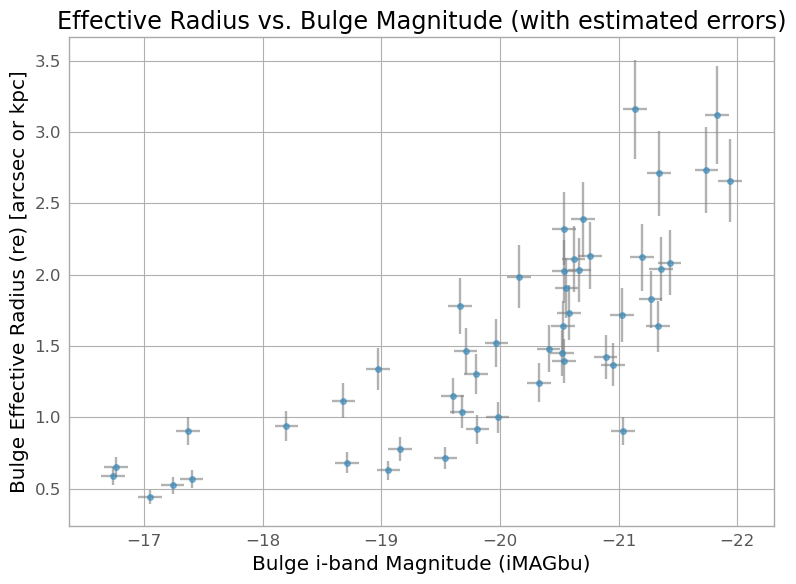

In [108]:
# For demonstration, use bulge effective radius vs. bulge i-band magnitude
x = data["iMAGbu"]
y = data["re"]

# Apply fixed uncertainties (you can refine these based on paper)
xerr = [0.1] * len(x)  # ±0.1 mag
yerr = 0.11 * y         # 20% of the effective radius

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ecolor='gray', alpha=0.6, markersize=4)
plt.gca().invert_xaxis()  # Bright galaxies have lower magnitudes
plt.xlabel("Bulge i-band Magnitude (iMAGbu)")
plt.ylabel("Bulge Effective Radius (re) [arcsec or kpc]")
plt.title("Effective Radius vs. Bulge Magnitude (with estimated errors)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
magnitudes['effective_magnitude'], rad

In [ ]:
import matplotlib.pyplot as plt

# Ellipticals: use bulge i-band magnitude and bulge effective radius
#ellipticals = data[data["MType"].str.startswith("E", na=False)]
#ellipticals = ellipticals[["iMAGbu", "re"]].dropna()

# Ellipticals
ellipticals = data[data["MType"] == "elliptical"][["iMAGbu", "re"]].dropna()

# Disks – select bulgeless, pseudo-bulge, or classical (depending on your definition)
disks = data[data["MType"].isin(["pseudo-bulge", "classical", "bulgeless"])][["iMAGd", "h"]].dropna()


x_e = ellipticals["iMAGbu"]
y_e = ellipticals["re"]
xerr_e = [0.1] * len(x_e)
yerr_e = 0.2 * y_e  # 20% uncertainty on effective radius

# Disks: use disk i-band magnitude and disk scalelength
# disks = data[data["MType"].str.startswith("S", na=False)]
#disks = disks[["iMAGd", "h"]].dropna()
x_d = disks["iMAGd"]
y_d = disks["h"]
xerr_d = [0.1] * len(x_d)
yerr_d = 0.2 * y_d  # 20% uncertainty on scalelength

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot ellipticals
axs[0].errorbar(x_e, y_e, xerr=xerr_e, yerr=yerr_e, fmt='o', ecolor='gray', alpha=0.6, markersize=4)
axs[0].invert_xaxis()
axs[0].set_title("Ellipticals (Bulge-dominated)")
axs[0].set_xlabel("Bulge i-band Magnitude (iMAGbu)")
axs[0].set_ylabel("Effective Radius (re) [arcsec]")

# Plot disks

axs[1].scatter(magnitudes['effective_magnitude'], rad, color='green', s=100, alpha=0.9, label='M83')
axs[1].errorbar(magnitudes['effective_magnitude'], rad, xerr=[0.1], yerr=[0.2 * rad[0]], fmt='o', color='green', ecolor='green', alpha=0.9)

axs[1].errorbar(x_d, y_d, xerr=xerr_d, yerr=yerr_d, fmt='o', ecolor='gray', alpha=0.6, markersize=4)
axs[1].invert_xaxis()
axs[1].set_title("Disks (Disk-dominated)")
axs[1].set_xlabel("Disk i-band Magnitude (iMAGd)")

plt.suptitle("Galaxy Size vs. Magnitude (Gadotti 2009)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
# 6.2

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture, aperture_photometry

# Charger ton image finale calibrée
image_data = fits.getdata('./Processed/M83_Red_final_calibrated.fits')  # Exemple avec Red

# Définir le centre de la galaxie (à ajuster si besoin)
x_center = 2048
y_center = 2048
positions = [(x_center, y_center)]

# Définir différentes tailles d'ouverture (en pixels)
radii = [50, 100, 150, 200, 250]  # Rayons en pixels

# Faire des mesures d'ouverture
for r in radii:
    aperture = CircularAperture(positions, r=r)
    phot_table = aperture_photometry(image_data, aperture)
    flux = phot_table['aperture_sum'][0]
    print(f"Rayon : {r} pixels → Flux mesuré : {flux:.2f} ADU")


In [ ]:
# Photométrie simple avec photutils
from photutils.aperture import CircularAperture, aperture_photometry

positions = [(x0, y0)]  # centre de la galaxie
radii = [10, 15, 20, 25, 30]  # à adapter

for r in radii:
    aperture = CircularAperture(positions, r=r)
    phot_table = aperture_photometry(stacked_image, aperture)
    print(f"Rayon {r}: flux = {phot_table['aperture_sum']}")

## 6. Étude statistique loi taille-luminosité

In [ ]:
# Exemple de tracé final
luminosities = [...]  # µJy
radii_kpc = [...]     # kpc
types = [...]         # par exemple ["spirale", "elliptique", ...]

plt.scatter(luminosities, radii_kpc, c=type_color_map[types], label=types)
plt.xlabel("Luminosité (µJy)")
plt.ylabel("Rayon effectif (kpc)")
plt.title("Relation taille-luminosité")
plt.legend()
plt.grid()
plt.show()

## 7. Discussion

- Incertitudes principales :
  * fond de ciel
  * étalonnage du point-zéro
  * qualité des poses
- Comportement selon le type morphologique ?
- Alignement avec les résultats de Gadotti (2009) ?